In [2]:
%matplotlib inline
from matplotlib import style
#style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import os

In [4]:
import datetime as dt
import matplotlib.dates as mdates

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Visualize Measurment first set of data as a dictionary
first_row = session.query(Measurement).first()
first_row.__dict__

# 'date' and 'prcp' keys are what I need to extract and use date formating 

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x163e24f6e80>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [12]:
# Visualize Station first set of data as a dictionary
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x163e2536a90>,
 'elevation': 3.0,
 'longitude': -157.8168,
 'name': 'WAIKIKI 717.2, HI US',
 'id': 1,
 'latitude': 21.2716,
 'station': 'USC00519397'}

In [13]:
# Converting to DF
measurement_df = pd.read_sql("SELECT * FROM Measurement", conn)
measurement_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


C:\Users\amand\Anaconda3\lib\site-packages\pandas\core\indexes\base.py:2084: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return getitem(key)


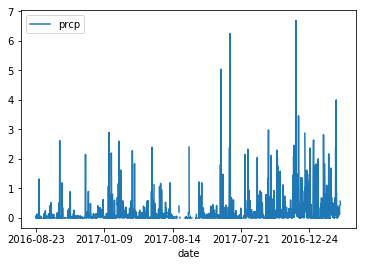

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
max_id = session.query(func.max(Measurement.date)).scalar()
#print(max_id) 

# Calculate the date 1 year ago from the last data point in the database
maxDate = dt.date(2017, 8 ,23)
year_ago = maxDate - dt.timedelta(days=365)
#print("Date year ago: ", year_ago)

# Perform a query to retrieve the data and precipitation scores
pdata = [Measurement.date, Measurement.prcp]

prcp_data = session.query(*pdata).\
    filter(Measurement.date <= maxDate).\
    filter(Measurement.date >= year_ago).all()
#prcp_data

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_data, columns=['date', 'prcp'])
#prcp_df.head()

# Sort the dataframe by date
#prcp_df.sort_values(by='date')

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df.plot(x='date', y='prcp')
plt.xlabel("date")
plt.show()

In [15]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [16]:
# Design a query to show how many stations are available in this dataset?
stations = session.query(Station).group_by(Station.station).count()
stations

9

In [17]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
staions_active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
staions_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
max = session.query(func.max(Measurement.tobs)).all()
min = session.query(func.min(Measurement.tobs)).all()
avrg = session.query(func.avg(Measurement.tobs)).all()

print(min, max, avrg)

[(53.0,)] [(87.0,)] [(73.09795396419437,)]


In [19]:
# Choose the station with the highest number of temperature observations.
active = session.query(Measurement.station, Station.name, func.count(Measurement.station)).\
filter(Measurement.station == Station.station).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).first()

#active

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tdata = [Measurement.date, Measurement.tobs, Measurement.station]

temp_data = session.query(*tdata).\
    filter(Measurement.station=='USC00519281').\
    filter(Measurement.date <= maxDate).\
    filter(Measurement.date >= year_ago).all()

temp_data


[('2016-08-23', 77.0, 'USC00519281'),
 ('2016-08-24', 77.0, 'USC00519281'),
 ('2016-08-25', 80.0, 'USC00519281'),
 ('2016-08-26', 80.0, 'USC00519281'),
 ('2016-08-27', 75.0, 'USC00519281'),
 ('2016-08-28', 73.0, 'USC00519281'),
 ('2016-08-29', 78.0, 'USC00519281'),
 ('2016-08-30', 77.0, 'USC00519281'),
 ('2016-08-31', 78.0, 'USC00519281'),
 ('2016-09-01', 80.0, 'USC00519281'),
 ('2016-09-02', 80.0, 'USC00519281'),
 ('2016-09-03', 78.0, 'USC00519281'),
 ('2016-09-04', 78.0, 'USC00519281'),
 ('2016-09-05', 78.0, 'USC00519281'),
 ('2016-09-06', 73.0, 'USC00519281'),
 ('2016-09-07', 74.0, 'USC00519281'),
 ('2016-09-08', 80.0, 'USC00519281'),
 ('2016-09-09', 79.0, 'USC00519281'),
 ('2016-09-10', 77.0, 'USC00519281'),
 ('2016-09-11', 80.0, 'USC00519281'),
 ('2016-09-12', 76.0, 'USC00519281'),
 ('2016-09-13', 79.0, 'USC00519281'),
 ('2016-09-14', 75.0, 'USC00519281'),
 ('2016-09-15', 79.0, 'USC00519281'),
 ('2016-09-16', 78.0, 'USC00519281'),
 ('2016-09-17', 79.0, 'USC00519281'),
 ('2016-09-1

In [20]:
tobs_df = pd.DataFrame(temp_data, columns=['date','tobs','station'])
tobs = tobs_df['tobs']
tobs_df.head()

,date,tobs,station
0,2016-08-23,77.0,USC00519281
1,2016-08-24,77.0,USC00519281
2,2016-08-25,80.0,USC00519281
3,2016-08-26,80.0,USC00519281
4,2016-08-27,75.0,USC00519281


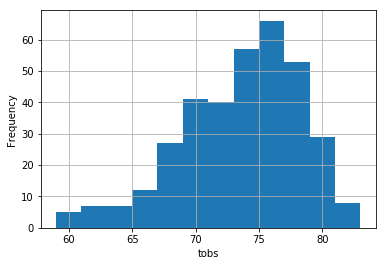

In [21]:
plt.hist(tobs, bins=12)
plt.xlabel('tobs')
plt.ylabel('Frequency')
plt.grid()
plt.show()

In [22]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-06-10', '2017-06-30'))

#print(calc_temps('2012-02-28', '2012-03-05'))
#[(62.0, 69.57142857142857, 74.0)]

[(71.0, 76.96992481203007, 83.0)]


In [23]:
# Calculate date 1 year ago
endDate = dt.date(2017, 6 ,10)
Newyear_ago = endDate - dt.timedelta(days=365)
#print("Date year ago: ", Newyear_ago)

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2016-06-10', '2016-06-30'))

[(69.0, 76.1970802919708, 81.0)]


C:\Users\amand\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


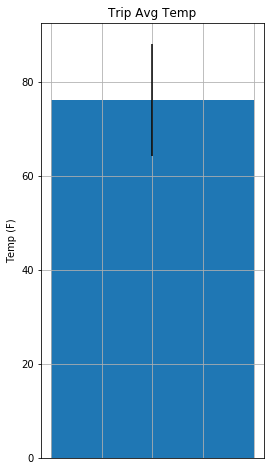

In [24]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
tmax = 81
tmin = 69
tavg = 76.1970802919708
difftemp = tmax - tmin

plt.figure(figsize=(4, 8))
plt.tick_params(bottom='off', top='off', labelbottom='off')
plt.bar(1, tavg, yerr=difftemp)
plt.ylabel('Temp (F)')
plt.title('Trip Avg Temp')
plt.grid()
plt.show()


In [25]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
#start_date = 2016-06-10
#end_date = 2016-06-30

endDate = dt.date(2016, 6 ,10)
year_ago2 = endDate - dt.timedelta(days=365)

sel = [Measurement.station, Measurement.prcp, Station.name, Station.longitude, Station.latitude, Station.elevation]

rainfall_data = session.query(*sel).\
    filter(Measurement.date <= endDate).\
    filter(Measurement.date >= year_ago2).\
    group_by(Station.name).\
    order_by(Measurement.prcp).all()

rainfall_data

[('USC00519397',
  0.0,
  'HONOLULU OBSERVATORY 702.2, HI US',
  -157.9992,
  21.3152,
  0.9),
 ('USC00519397', 0.0, 'KANEOHE 838.1, HI US', -157.8015, 21.4234, 14.6),
 ('USC00519397',
  0.0,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  -157.8374,
  21.5213,
  7.0),
 ('USC00519397',
  0.0,
  'MANOA LYON ARBO 785.2, HI US',
  -157.8025,
  21.3331,
  152.4),
 ('USC00519397', 0.0, 'PEARL CITY, HI US', -157.9751, 21.3934, 11.9),
 ('USC00519397', 0.0, 'UPPER WAHIAWA 874.3, HI US', -158.0111, 21.4992, 306.6),
 ('USC00519397',
  0.0,
  'WAIHEE 837.5, HI US',
  -157.84888999999998,
  21.45167,
  32.9),
 ('USC00519397', 0.0, 'WAIKIKI 717.2, HI US', -157.8168, 21.2716, 3.0),
 ('USC00519397',
  0.0,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  -157.71139,
  21.33556,
  19.5)]

# Step 2 - Climate App

In [26]:
from flask import Flask, jsonify

In [27]:
app = Flask(__name__)

In [28]:
# Homepage: List all routes that are available

@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )

In [ ]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    maxDate = dt.date(2017, 8 ,23)
    year_ago = maxDate - dt.timedelta(days=365)

    past_temp = (session.query(Measurement.date, Measurement.prcp)
                .filter(Measurement.date <= maxDate)
                .filter(Measurement.date >= year_ago)
                .order_by(Measurement.date).all())
    
    precip = {date: prcp for date, prcp in past_temp}
    
    return jsonify(precip)


In [ ]:
@app.route('/api/v1.0/stations')
def stations():

    stations_all = session.query(Station.station).all()

    return jsonify(stations_all)

In [ ]:
@app.route('/api/v1.0/tobs') 
def tobs():  
    maxDate = dt.date(2017, 8 ,23)
    year_ago = maxDate - dt.timedelta(days=365)

    lastyear = (session.query(Measurement.tobs)
                .filter(Measurement.station == 'USC00519281')
                .filter(Measurement.date <= maxDate)
                .filter(Measurement.date >= year_ago)
                .order_by(Measurement.tobs).all())
    
    return jsonify(lastyear)

In [ ]:
@app.route('/api/v1.0/<start>') 
def start(start=None):

    #start = Measurement.date <= '2010-01-01'
    #end = Measurement.date >= '2017-08-23'

    tobs_only = (session.query(Measurement.tobs).filter(Measurement.date.between(start, '2017-08-23')).all())
    
    tobs_df = pd.DataFrame(tobs_only)

    tavg = tobs_df["tobs"].mean()
    tmax = tobs_df["tobs"].max()
    tmin = tobs_df["tobs"].min()
    
    return jsonify(tavg, tmax, tmin)

In [ ]:
@app.route('/api/v1.0/<start>/<end>') 
def startend(start=None, end=None):

    #start = Measurement.date <= '2010-01-01'
    #end = Measurement.date >= '2017-08-23'

    tobs_only = (session.query(Measurement.tobs).filter(Measurement.date.between(start, end)).all())
    
    tobs_df = pd.DataFrame(tobs_only)

    tavg = tobs_df["tobs"].mean()
    tmax = tobs_df["tobs"].max()
    tmin = tobs_df["tobs"].min()
    
    return jsonify(tavg, tmax, tmin)

In [ ]:
if __name__ == '__main__':
    app.run(debug=True)